# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [45]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [46]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [119]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count("!")
    
    #toxic_data['uppercount'] = toxic_data['comment_text']
    count1=0
    count2=0
    for i in toxic_data['comment_text']:
      if(i.islower()):
            count1=count1+1
      elif(i.isupper()):
            count2=count2+1
    print("The number of lowercase characters is:")
    print(count1)
    print("The number of uppercase characters is:")
    print(count2)

    toxic_data['up_count'] = count2
    
    X_quant_features = toxic_data[["word_count", "punc_count", "excl_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [120]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/toxiccomments_train.csv', my_random_seed=700)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [12]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 6273, 'TN': 59734, 'FP': 55016, 'FN': 6633, 'Accuracy': 0.517069311274049, 'Precision': 0.10235115599862944, 'Recall': 0.4860529986052999, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [21]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 12784, 'TN': 114656, 'FP': 94, 'FN': 122, 'Accuracy': 0.9983079526226735, 'Precision': 0.9927007299270073, 'Recall': 0.9905470323880365, 'desc': 'svm_train'}


### MODEL: logistic regression

In [121]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 12837, 'TN': 114707, 'FP': 43, 'FN': 69, 'Accuracy': 0.9991226421006455, 'Precision': 0.9966614906832298, 'Recall': 0.9946536494653649, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [104]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 12758, 'TN': 96228, 'FP': 18522, 'FN': 148, 'Accuracy': 0.8537475715986714, 'Precision': 0.40786445012787725, 'Recall': 0.9885324655199133, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [105]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 12362, 'TN': 114623, 'FP': 127, 'FN': 544, 'Accuracy': 0.9947436861565457, 'Precision': 0.9898310513251661, 'Recall': 0.9578490624515729, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [122]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12906, 'Neg': 114750, 'TP': 12868, 'TN': 99951, 'FP': 14799, 'FN': 38, 'Accuracy': 0.8837735789935451, 'Precision': 0.4651028300863845, 'Recall': 0.9970556330388967, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [123]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=100, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/robincoenen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12906, 'Neg': 114750, 'TP': 5940, 'TN': 114749, 'FP': 1, 'FN': 6966, 'Accuracy': 0.9454236385285455, 'Precision': 0.9998316781686585, 'Recall': 0.4602510460251046, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

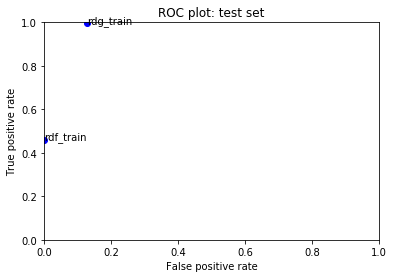

In [124]:
fits = [#rdf_performance_train,
        #ols_performance_train, 
        #svm_performance_train, 
        #lgs_performance_train,  
        #prc_performance_train, 
        #nbs_performance_train, 
        rdg_performance_train, 
        rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [130]:
rdf_predictions = rdf.predict(X_train)

### let's look at some false positives:

In [131]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdf_predictions)):
    if (rdf_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1509, 'TN': 14636, 'FP': 14061, 'FN': 1709, 'Accuracy': 0.505874980416732, 'Precision': 0.09691714836223507, 'Recall': 0.4689247980111871, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2050, 'TN': 27199, 'FP': 1498, 'FN': 1168, 'Accuracy': 0.916465611781294, 'Precision': 0.5777903043968433, 'Recall': 0.637041640770665, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2055, 'TN': 27118, 'FP': 1579, 'FN': 1163, 'Accuracy': 0.914084286385712, 'Precision': 0.5654925701706109, 'Recall': 0.6385954008701057, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2088, 'TN': 23600, 'FP': 5097, 'FN': 1130, 'Accuracy': 0.804887983706721, 'Precision': 0.2906054279749478, 'Recall': 0.6488502175264139, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2072, 'TN': 27145, 'FP': 1552, 'FN': 1146, 'Accuracy': 0.9154629484568385, 'Precision': 0.5717439293598234, 'Recall': 0.6438781852082038, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [132]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3319, 'Neg': 28596, 'TP': 3193, 'TN': 22695, 'FP': 5901, 'FN': 126, 'Accuracy': 0.8111546294845684, 'Precision': 0.35111062238838797, 'Recall': 0.9620367580596565, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [133]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3319, 'Neg': 28596, 'TP': 682, 'TN': 28577, 'FP': 19, 'FN': 2637, 'Accuracy': 0.9167789440701865, 'Precision': 0.9728958630527818, 'Recall': 0.20548357939138295, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

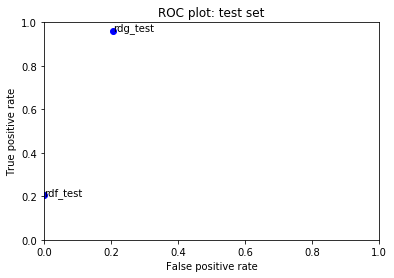

In [134]:
fits = [#ols_performance_test, 
        #svm_performance_test, 
        #lgs_performance_test, 
        #nbs_performance_test, 
        #prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [135]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../data/toxiccomments_train.csv', my_random_seed=700, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 8 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1     

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [144]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdf.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.041624104630540636


In [145]:
raw_data.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,punc_count,excl_count,up_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,42,5,0,1702
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,18,2,1,1702
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,3,0,1702
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,112,3,0,1702
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,1,0,1702
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,12,1,0,1702
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,8,0,0,1702
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,21,2,0,1702
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,83,7,0,1702
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,12,0,0,1702


In [146]:
my_submission.head(20)

,id,prediction
0,0000997932d777bf,False
1,000103f0d9cfb60f,False
2,000113f07ec002fd,False
3,0001b41b1c6bb37e,False
4,0001d958c54c6e35,False
5,00025465d4725e87,False
6,0002bcb3da6cb337,False
7,00031b1e95af7921,False
8,00037261f536c51d,False
9,00040093b2687caa,False


In [147]:
my_submission.shape

(159571, 2)

In [148]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('../data/toxiccomments_submission_rdf_final_final.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation